In [114]:
from timm.models.vision_transformer import VisionTransformer
import torch.nn as nn


class SimCLRViT(VisionTransformer):
    def __init__(self, device="cuda"):
        super().__init__(
            img_size=28,
            patch_size=4,
            in_chans=1,
            num_classes=10,
            embed_dim=64,
            depth=4,
            num_heads=4,
            mlp_ratio=4,
            norm_layer=nn.LayerNorm,
            device=device,
        )

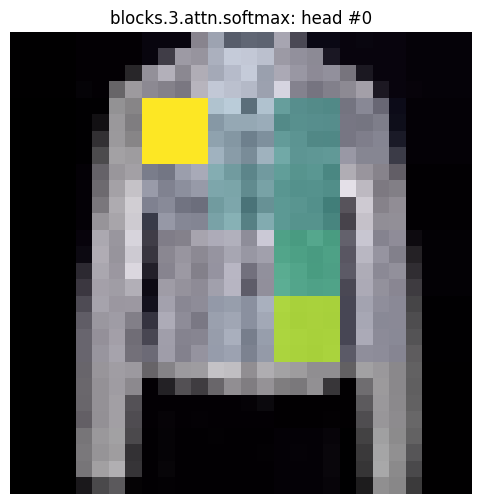

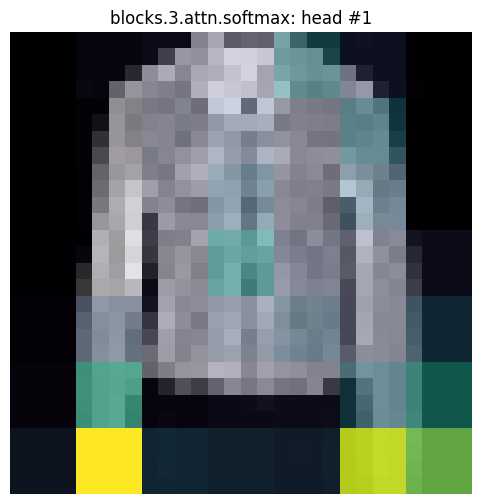

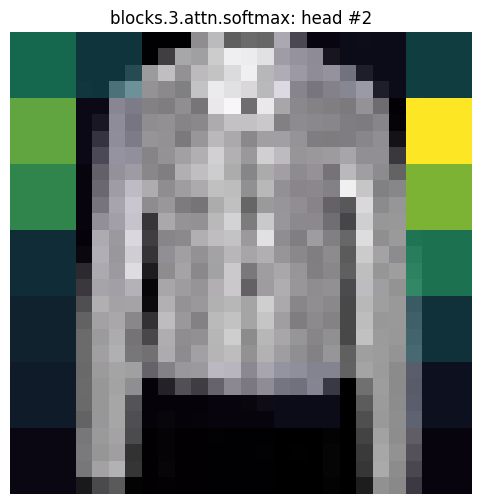

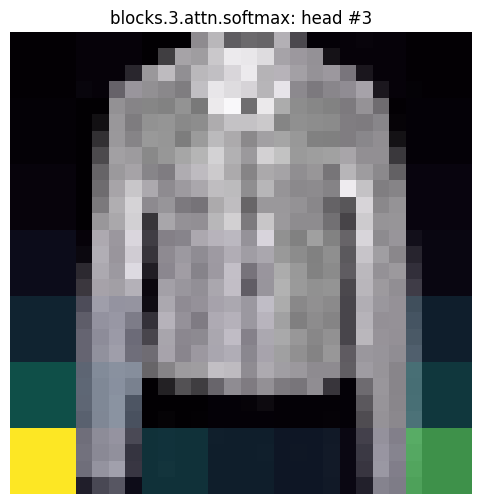

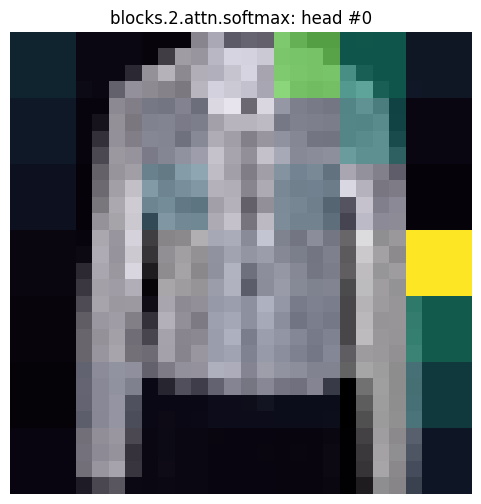

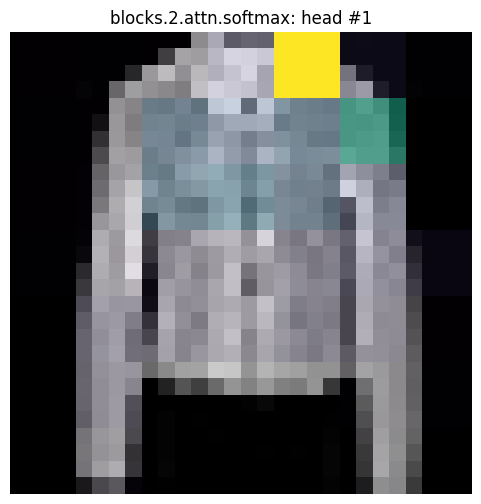

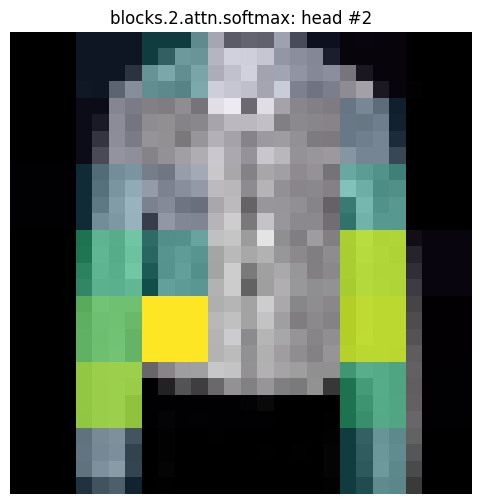

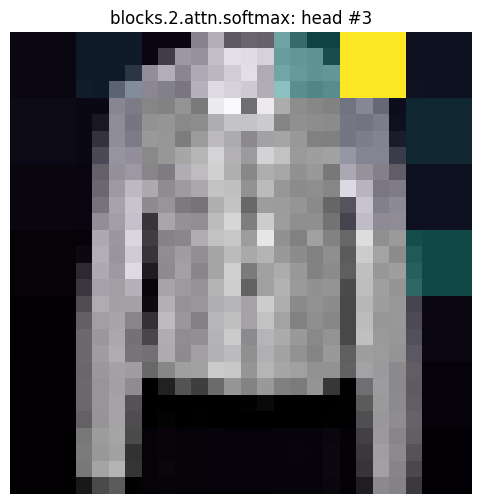

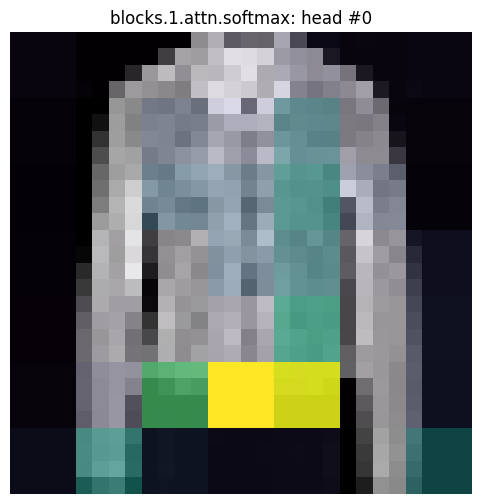

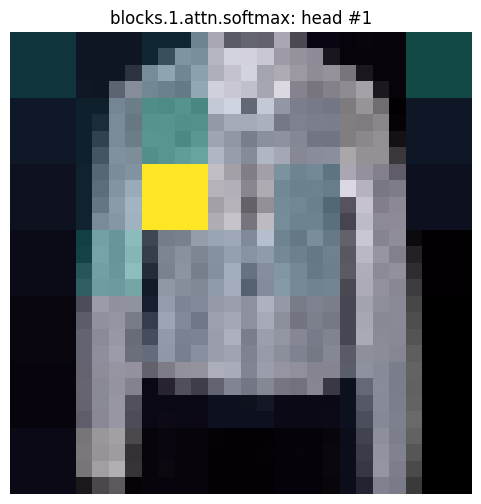

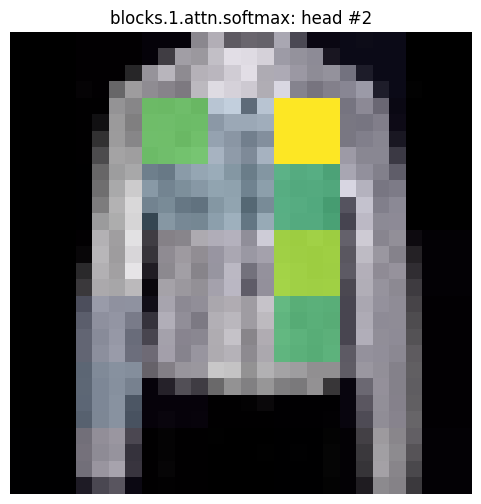

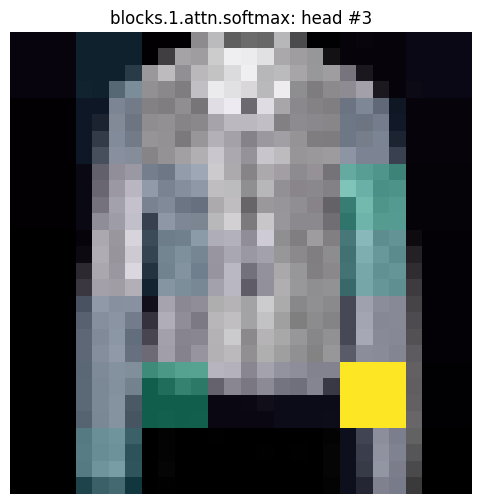

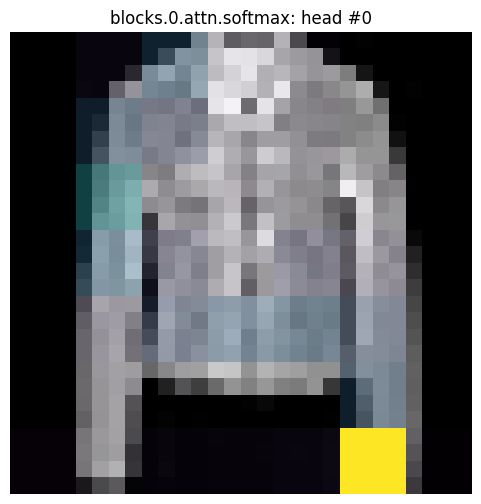

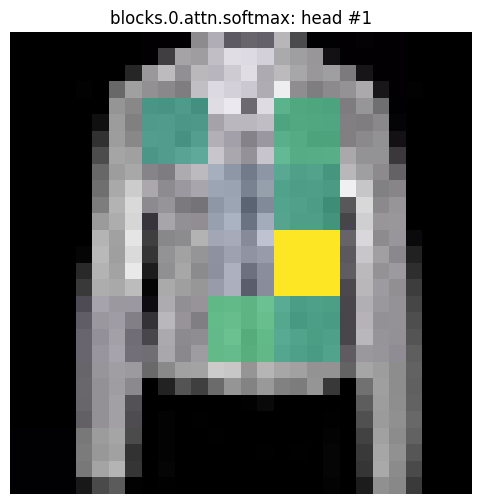

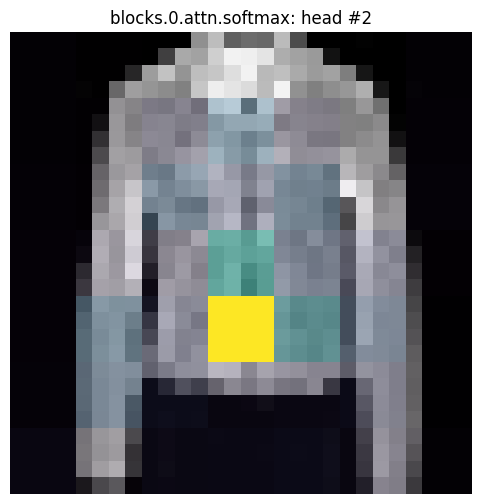

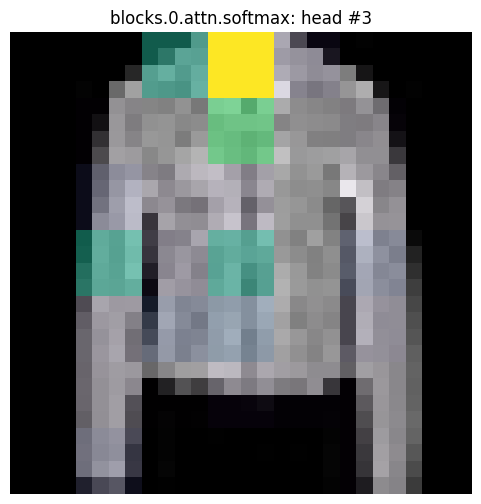

In [121]:
import torch
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
from model import DinoViT
from timm.utils.attention_extract import AttentionExtract
from timm.layers import set_fused_attn
from PIL.Image import Image
import torch.nn.functional as F

# -----------------------------
# 1. Load a FashionMNIST image
# -----------------------------
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
image, label = dataset[10]

# Add batch dimension
img_batch = image.unsqueeze(0)

# -----------------------------
# 2. Load ViT model from timm
# -----------------------------
# vit_base_patch16_224 is standard pretrained ViT
set_fused_attn(False)
model = DinoViT(device="cuda")
model.load_state_dict(torch.load("DINO_ViT_simple_head.pth"))
# model = SimCLRViT(device='cuda')
# model.load_state_dict(torch.load("../lab2/ViT-simCLR.pth"))
# model.head = nn.Identity()
model.eval()

with torch.no_grad():
    extractor = AttentionExtract(model)

attention_maps = extractor(img_batch.to("cuda"))

patch_id_attendance = 0  # 0 for cls token
patch_width = 7
patch_height = 7

for block, attn_maps in reversed(attention_maps.items()):
    for head_id, attn_map in enumerate(attn_maps[0]):
        attn_map = attn_map[patch_id_attendance, 1:].reshape(7, 7)
        resized_map = F.interpolate(
            attn_map.unsqueeze(0).unsqueeze(0), size=(28, 28)
        ).squeeze(0)
        resized_map = (resized_map - resized_map.min()) / (
            resized_map.max() - resized_map.min()
        )
        image_preview = ((image + 1) / 2)
        resized_map = resized_map.permute(1, 2, 0).detach().cpu().numpy()
        image_preview = image_preview.permute(1, 2, 0)

        plt.figure(figsize=(6,6))
        plt.imshow(image_preview, cmap='gray')
        plt.imshow(resized_map, alpha=resized_map.squeeze(2))
        plt.axis('off')
        plt.title(f"{block}: head #{head_id}")
        plt.show()